<a href="https://colab.research.google.com/github/rubanzasilva/random_forest_basics/blob/main/random_forests_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

#hide
#This imports and sets up everything you will need for this notebook
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.9 MB/s eta 0:00:00
Mounted at /content/gdrive


In [2]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

# for working with paths in Python, I recommend using `pathlib.Path`
from pathlib import Path
import os
import seaborn as sns
from numpy import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from ipywidgets import interact

Data PreProcessing

In [ ]:
creds = '{"username":"rubanzasilva","key":"7590231111c5bbe2ad242827b0ef016c"}'

In [3]:
creds = '{"username":"rubanzasilva","key":"7590231111c5bbe2ad242827b0ef016c"}'

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)


In [4]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle: path = Path('../input/titanic')
else:
    import zipfile,kaggle
    path = Path('titanic')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

#train_df = pd.read_csv(path/'train.csv')
#test_df = pd.read_csv(path/'test.csv')

100%|██████████| 34.1k/34.1k [00:00<00:00, 34.9MB/s]

In [5]:
train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')

Preprocessing

We do the same processing we had done in our previous linear model.

With random forests, we dont need to create dummy variables instead we turn our variables into categorical which assigns each level in a column a number/label.The number is an index for looking up that particular value in a list of unique values.

Lets create a function for our transformations.

In [6]:
modes = train_df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [7]:
def proc_data(df):
    df['Fare'] = df.Fare.fillna(0)
    df.fillna(modes, inplace=True)
    df['LogFare'] = np.log1p(df['Fare'])
    df['Embarked'] = pd.Categorical(df.Embarked)
    df['Sex'] = pd.Categorical(df.Sex)

In [8]:
proc_data(train_df)
proc_data(test_df)

In [9]:
train_df.shape

(891, 13)

Previously we had defined sex, embarked, and pclass as our categorical variables. We turn these into categorical variables here which for every value, assigns each value a number within a list of unique values.

We also notice that Pclass is an ordered variable, in decision trees we see that the order of classes carries some significant information about the data. This means that the decision tree can make decisions based on the order of our variables and not just the distinct values.

The model takes into account the order and hierarchy in the data which leads to more accurate predictions.

In [10]:
cats = ['Embarked', 'Sex']
conts = ['Pclass','Age','SibSp','Parch','LogFare']
dep = 'Survived'

In [11]:
train_df.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: category
Categories (2, object): ['female', 'male']

In [12]:
train_df.Sex.cat.codes.head()

0    1
1    0
2    0
3    0
4    1
dtype: int8

train_df.Sex are now categorical variables but when queried, pandas still show them as the original values but behind the scenes they are stored as ints with indices that can be looked up in the Categories list.

We can view the stored values for a variable by using the cat.codes attribute.

##Binary Split

To create a random forest or a gradient boosting machine, we need to create a decision tree which in turn is made up of binary splits.

A binary split is where all rows are placed into 1 of 2 groups based on whether they are above or below some threshold of some column.

> For example, we could split the rows of our dataset into males and females, by using the threshold 0.5 and the column Sex (since the values in the column are 0 for female and 1 for male).

We use a plot to see how that would split up our data, we use the seaborn library built upon matplotlib


[Text(0.5, 1.0, 'Histogram')]

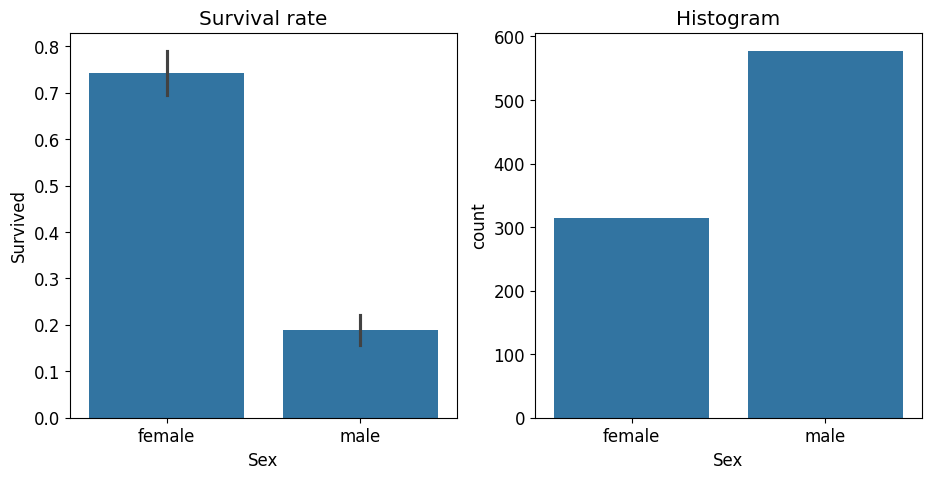

In [13]:
fig, axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=train_df, y=dep, x="Sex", ax=axs[0]).set(title="Survival rate")
sns.countplot(data=train_df, x="Sex", ax=axs[1]).set(title="Histogram")

*find a way to color code the plot*
fastai book plot is color coded this one isnt why ?
probably due to depreceiation.


We can look at the outputs of our plot, first in the barplot we see that the survival rates for our two groups vary significantly with the females having a survival rate of >70% while males survival rate is < 20%.

With this we can create a model that says all female passenger survive while male passengers dont, then we can check to see accurate this model is.

Before we do this, lets split our data into the training and validation set using the Sklearn *TrainTestSplit*. We also set the random seed for reproducibilty.

Remember, we need a numerical input so we use a lambda function to replace our categorical variables with our categorical codesby using a lambda function to apply the .cat.codes attribute to the columns in our cat variable.

A lambda function is defined as *lambda arguments: expression.*


In [14]:
random.seed(42)
trn_df,val_df = train_test_split(train_df, test_size=0.25)
trn_df[cats] = trn_df[cats].apply(lambda x:x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x:x.cat.codes)

Lets now create our input i.e. our independent variables (x) and dependent variable (y). We define a function xs_y which takes our dataframe, creates a new independent variable xs, and returns xs alongside the dependent variable if available.

This is copy of our dataframe where we add up the continous and categorical variables.

In [15]:
def xs_y(df):
  xs = df[cats + conts].copy()
  return xs,df[dep] if dep in df else None

trn_xs, trn_y = xs_y(trn_df)
val_xs, val_y = xs_y(val_df)

Lets calculate our predictions

In [16]:
preds = val_xs.Sex == 0
preds

709    False
439    False
840    False
720     True
39      True
       ...  
880     True
425    False
101    False
199     True
424    False
Name: Sex, Length: 223, dtype: bool

In [17]:
val_xs.shape

(223, 7)

In [18]:
trn_xs.shape

(668, 7)

In [19]:
#trn_preds = trn_xs.Sex == 0
#trn_preds

In [20]:
preds.shape

(223,)

We can now use Mean Absolute Error to measure how good our model is.

In [21]:
#from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y,preds)

0.21524663677130046

Summary

So far my idea of binary splits, is we choose a value that seems like a good split, split alongside that into two groups with each group representign a different pred for example 1 and 0 for survived or not respectively.

We split on a particular value, say male and female for example we might say all males didnt survive while all females did.We then calculate preds with this logic i.e. if passenger if female, then they survived. We then test how good this model is using a loss function.

Alternatively, we can split on a continous column.Lets look at LogFare.

<Axes: xlabel='LogFare', ylabel='Density'>

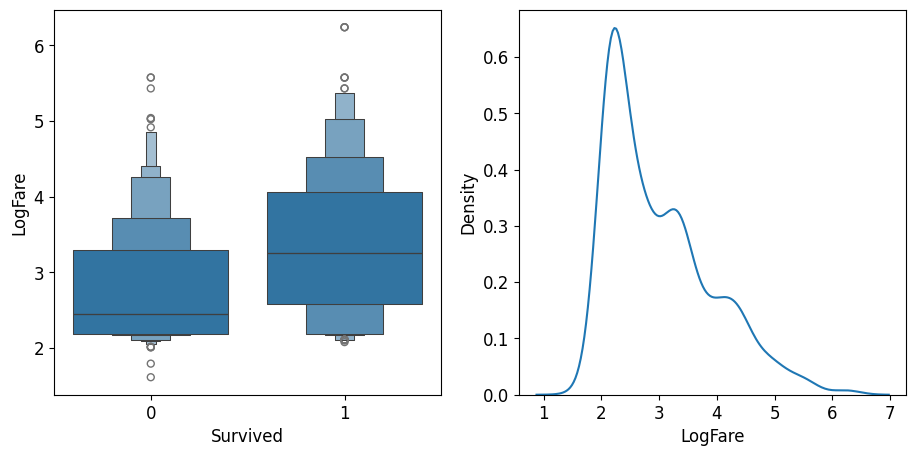

In [22]:
df_fare = trn_df[trn_df.LogFare>0]
fig, axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_fare, x=dep, y="LogFare", ax=axs[0])
sns.kdeplot(data=df_fare, x ="LogFare", ax=axs[1])

We notice that people with higher LogFare had a higher chance of surviving.


> The boxenplot above shows quantiles of LogFare for each group of Survived==0 and Survived==1. It shows that the average LogFare for passengers that didn't survive is around 2.5, and for those that did it's around 3.2. So it seems that people that paid more for their tickets were more likely to get put on a lifeboat.

We now create a simple model based on this observation and test how good it is.

In [23]:
preds = val_xs.LogFare > 2.7
preds

709     True
439    False
840    False
720     True
39     False
       ...  
880     True
425    False
101    False
199    False
424     True
Name: LogFare, Length: 223, dtype: bool

In [24]:
mean_absolute_error(val_y,preds)

0.336322869955157

So it did slightly worse than our model that used sex as a split.

We need a way to try our more columns and split points more easily and less manually.We create a function that returns a score based on how good a split is.

Instead of using mean squared error, we use a measure of impurity or how good a split is by calculating how similar the rows are for each group split.

We can measure the similarity of rows inside a group by taking the standard deviation from the dependent variable. The higher this number is the less similar the rows for a group are.

In [28]:
def _side_score(side,y):
  tot = side.sum()
  if tot<=1:
    return 0
  return y[side].std()*tot

In [40]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot

We now add up the score for a split by adding the scores for both the lhs and rhs.

In [29]:
def score(col,y,split):
  lhs = col <= split
  return (_side_score(lhs,y) + _side_score(-lhs,y))/len(y)

In [33]:
trn_xs.shape

(668, 7)

In [35]:
score(trn_xs["Sex"], trn_y, 0.5)

0.40787530982063946

In [36]:
score(trn_xs["LogFare"], trn_y, 2.7)

0.47180873952099694

This results in the same things as earlier, our Sex is a better split than the Log Fare.

We create an interactive tool to help us vary our split value so we can find the best split value.

In [44]:
def iscore(nm,split):
  col = trn_xs[nm]
  return score(col,trn_y,split)

#from ipywidgets import interact
interact(nm=conts, split=15.5)(iscore);

interactive(children=(Dropdown(description='nm', options=('Pclass', 'Age', 'SibSp', 'Parch', 'LogFare'), value…

We defined a function isscore which extracts a particular continous column and returns the score for that column showing the variabilty within the dependent variable for a particular split.

The interact function from the ipywidgets library is used to create an interactive widget that allows you to select a feature nm from a list of continuous features conts and specify a split value.

This widget calls the isscore function with the selected feature and split value, allowing you to dynamically calculate and visualize the scoring metric for different features and split values.


(https://www.phind.com/search?cache=lwc40psw6mf0gudnbnijyoff)

We also pass in the categorical variables, cats

In [45]:
interact(nm=cats, split=15.5)(iscore);

interactive(children=(Dropdown(description='nm', options=('Embarked', 'Sex'), value='Embarked'), FloatSlider(v…

This works but it is quite manual, we want to have a way to automatically find the best split point in a column for us. To calculate the best split point, first we need to have a list of all the possible split points

In [48]:
nm = "Age"
col = trn_xs[nm]
col

298    24.00
884    25.00
247    24.00
478    22.00
305     0.92
       ...  
106    21.00
270    24.00
860    41.00
435    14.00
102    21.00
Name: Age, Length: 668, dtype: float64

In [49]:
unq = col.unique()
unq.sort()
unq

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,  5.  ,  6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  ,
       13.  , 14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 21.  , 22.  , 23.  , 24.  , 24.5 , 25.  , 26.  , 27.  ,
       28.  , 28.5 , 29.  , 30.  , 31.  , 32.  , 32.5 , 33.  , 34.  , 34.5 , 35.  , 36.  , 36.5 , 37.  , 38.  , 39.  , 40.  ,
       40.5 , 41.  , 42.  , 43.  , 44.  , 45.  , 45.5 , 46.  , 47.  , 48.  , 49.  , 50.  , 51.  , 52.  , 53.  , 54.  , 55.  ,
       55.5 , 56.  , 57.  , 58.  , 59.  , 60.  , 61.  , 62.  , 64.  , 65.  , 70.  , 70.5 , 74.  , 80.  ])

We return the index of the value which results in the best split.

In [50]:
scores = np.array([score(col, trn_y, o) for o in unq if not np.isnan(0)])
unq[scores.argmin()]

6.0

In [52]:
twer = scores.argmin()
twer

10

scores.argmin() returns the index of the value with the lowest score. unq[scores.argmin] returns that value for example for age, we see that 6 seems to be the number that reuslts in the best split.

Lets write a function that implements this idea.


In [ ]:
def min_col()

Acknowledgements

https://www.kaggle.com/code/jhoward/how-random-forests-really-work/
